# Match Analysis

In [1]:
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

### Styling

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
# plt.style.available

In [3]:
color_code = {
    'CSK': ['#f9cd05', '#1d418c'],
    'DC': ['#2561ae', '#d71921'],
    'KKR': ['#2e0854', '#b3a123'],
    'MI': ['#004ba0', '#d1ab3e'],
    'PBKS': ['#ed1b24', '#dcdddf'],
    'RCB': ['#2b2a29', '#ec1c24'],
    'RR': ['#254aa5', '#cba92b'],
    'SRH': ['#f7a721', '#352722'],}

## Reading Data

In [4]:
# Reading Match Data (ball by ball)
path = '../dataset/csv/Match 60 (CSK vs KKR) 2021-10-15.csv'

match = pd.read_csv(
    path,
    index_col=0
)
match.head(6)

,inning,batting_team,bowling_team,ball,non_striker,batsman,bowler,extra_runs,batsman_run,total_runs,extras,player_out,elimination_kind,fielders_caught
0,1st innings,Chennai Super Kings,Kolkata Knight Riders,0.1,F du Plessis,RD Gaikwad,Shakib Al Hasan,0,1,1,0,0,0,0
1,1st innings,Chennai Super Kings,Kolkata Knight Riders,0.2,RD Gaikwad,F du Plessis,Shakib Al Hasan,0,0,0,0,0,0,0
2,1st innings,Chennai Super Kings,Kolkata Knight Riders,0.3,RD Gaikwad,F du Plessis,Shakib Al Hasan,0,1,1,0,0,0,0
3,1st innings,Chennai Super Kings,Kolkata Knight Riders,0.4,F du Plessis,RD Gaikwad,Shakib Al Hasan,0,4,4,0,0,0,0
4,1st innings,Chennai Super Kings,Kolkata Knight Riders,0.5,F du Plessis,RD Gaikwad,Shakib Al Hasan,0,0,0,0,0,0,0
5,1st innings,Chennai Super Kings,Kolkata Knight Riders,0.6,F du Plessis,RD Gaikwad,Shakib Al Hasan,0,0,0,0,0,0,0


In [5]:
# Reading Match Details

match_details = pd.read_csv(
    '../dataset/csv/Matche Details.csv',
    index_col=0
).loc[' '.join(re.split(r'[/]', path)[3].split()[:-1]), :]

match_details.to_frame()

,Match 60 (CSK vs KKR)
match_no,60
team_1,Chennai Super Kings
team_2,Kolkata Knight Riders
date,15 October 2021
day,Friday
umpire_1,Nitin Menon
umpire_2,RK Illingworth
player_of_match,F du Plessis
winner,Chennai Super Kings
city,Dubai


## Ploting Data

### Teams

In [6]:
team_names = [match_details['team_1'], match_details['team_2']]
team_names

['Chennai Super Kings', 'Kolkata Knight Riders']

In [7]:
team_abbreviation = list()
for team in team_names:
    team_abbreviation.append(''.join([x[0] for x in team.split()]))
team_abbreviation

['CSK', 'KKR']

In [8]:
color_1 = color_code[team_abbreviation[0]]
color_2 = color_code[team_abbreviation[1]]

color_1, color_2

(['#f9cd05', '#1d418c'], ['#2e0854', '#b3a123'])

In [9]:
teams = match.groupby('batting_team')[['batsman_run', 'extra_runs', 'total_runs']].sum()
teams

,batsman_run,extra_runs,total_runs
batting_team,,,
Chennai Super Kings,186,6,192
Kolkata Knight Riders,156,9,165


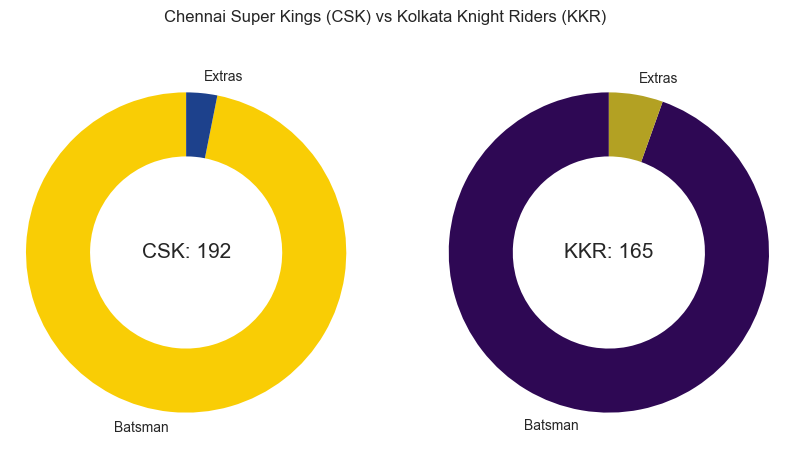

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].pie(
    teams.loc[team_names[0]][:2],
    startangle=90,
    wedgeprops=dict(width=.4),
    labels=['Batsman', 'Extras'],
    colors=color_1,
)

ax[1].pie(
    teams.loc[team_names[1]][:2],
    startangle=90,
    wedgeprops=dict(width=.4),
    labels=['Batsman', 'Extras'],
    colors=color_2,
)

ax[0].text(
    0., 0.,
    f"{team_abbreviation[0]}: {teams.loc[team_names[0]][2]}",
    horizontalalignment='center',
    verticalalignment='center',
    size=15
)
ax[0].axis('equal')

ax[1].text(
    0., 0.,
    f"{team_abbreviation[1]}: {teams.loc[team_names[1]][2]}",
    horizontalalignment='center',
    verticalalignment='center',
    size=15
)
ax[1].axis('equal')

fig.suptitle(f'{team_names[0]} ({team_abbreviation[0]}) vs {team_names[1]} ({team_abbreviation[1]})')

plt.plot();

---

### Over

In [11]:
team_1_runs_per_over = match[match['inning'] == '1st innings'].groupby(
    ['inning', 'batting_team', pd.cut(match['ball'], np.arange(21))]
).agg(
    runs=('total_runs', 'sum')
).reset_index([0, 1], drop=True).reset_index()

team_1_runs_per_over.columns = ['over', 'team_1_runs']

team_1_runs_per_over.head()

,over,team_1_runs
0,"(0, 1]",6
1,"(1, 2]",3
2,"(2, 3]",13
3,"(3, 4]",12
4,"(4, 5]",8


In [12]:
team_2_runs_per_over = match[match['inning'] == '2nd innings'].groupby(
    ['inning', 'batting_team', pd.cut(match['ball'], np.arange(21))]
).agg(
    runs=('total_runs', 'sum')
).reset_index([0, 1], drop=True).reset_index()

team_2_runs_per_over.columns = ['over', 'team_2_runs']

team_2_runs_per_over.head()

,over,team_2_runs
0,"(0, 1]",6
1,"(1, 2]",9
2,"(2, 3]",9
3,"(3, 4]",12
4,"(4, 5]",11


In [13]:
teams_run_per_over = team_1_runs_per_over.merge(
    team_2_runs_per_over,
    how='inner',
    left_on='over',
    right_on='over'
)

del [team_1_runs_per_over, team_2_runs_per_over]

teams_run_per_over['cumulative_team_1_runs'] = teams_run_per_over['team_1_runs'].cumsum()
teams_run_per_over['cumulative_team_2_runs'] = teams_run_per_over['team_2_runs'].cumsum()

teams_run_per_over.head()

,over,team_1_runs,team_2_runs,cumulative_team_1_runs,cumulative_team_2_runs
0,"(0, 1]",6,6,6,6
1,"(1, 2]",3,9,9,15
2,"(2, 3]",13,9,22,24
3,"(3, 4]",12,12,34,36
4,"(4, 5]",8,11,42,47


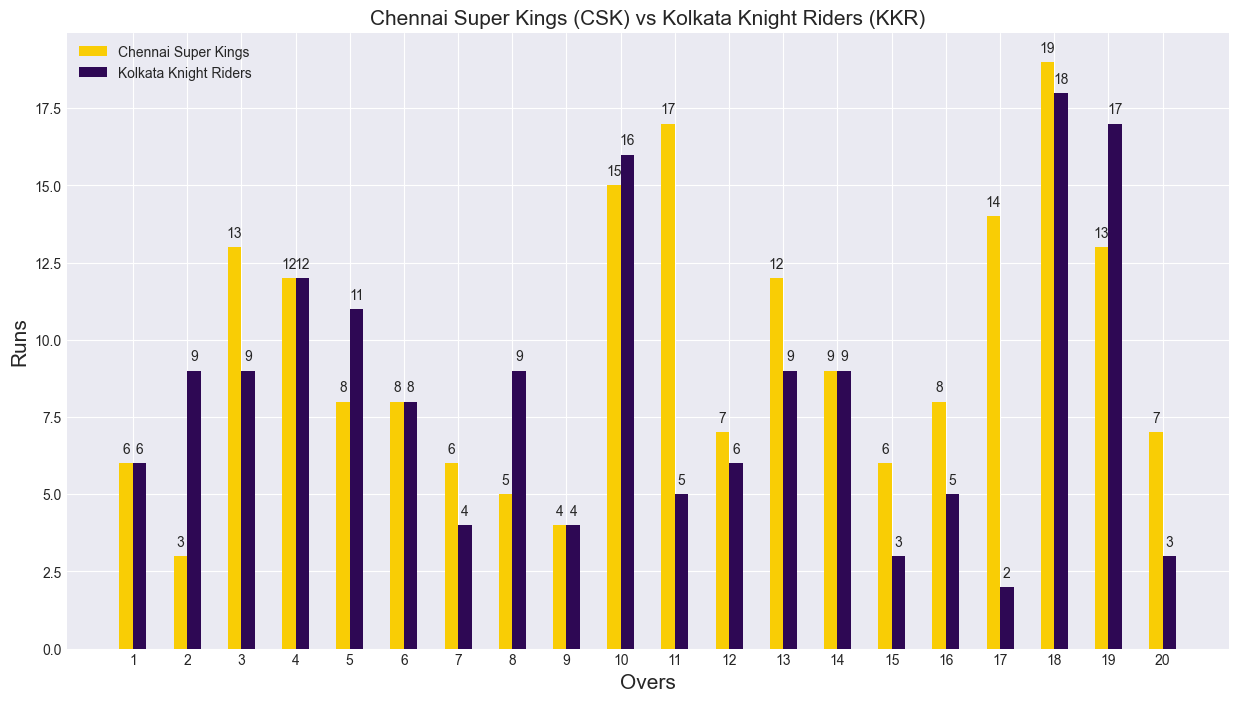

In [14]:
fig, ax = plt.subplots(figsize=(15, 8))

width = .25
x = np.arange(1, 21)

ax.bar(
    x - width / 2,
    teams_run_per_over['team_1_runs'],
    width=width,
    color=color_1[0],
    label=team_names[0]
)

ax.bar(
    x + width / 2,
    teams_run_per_over['team_2_runs'],
    width=width,
    color=color_2[0],
    label=team_names[1]
)

ax.set_title(f'{team_names[0]} ({team_abbreviation[0]}) vs {team_names[1]} ({team_abbreviation[1]})', size=15)
ax.set_xlabel('Overs', size=15)
ax.set_ylabel('Runs', size=15)
ax.set_xticks(x)

for score in ax.containers:
    ax.bar_label(score, size=10, padding=5)

ax.legend(prop={'size': 10})
plt.show();

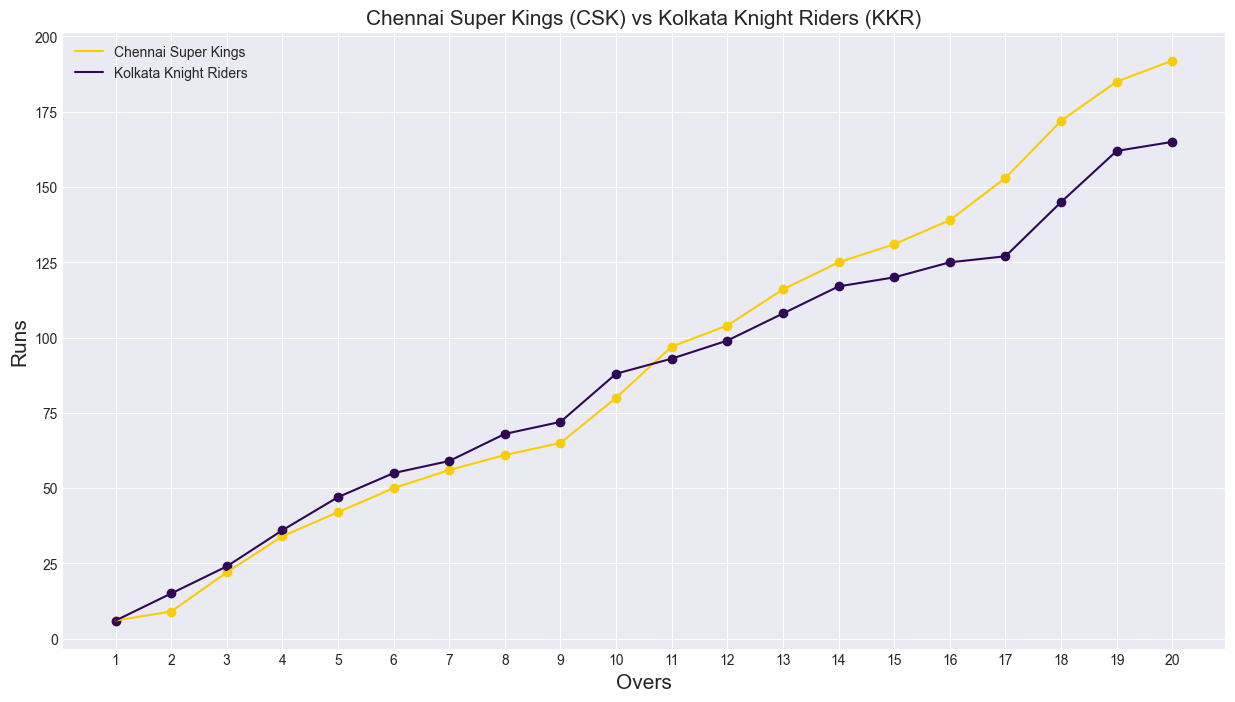

In [15]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(
    teams_run_per_over.index + 1,
    teams_run_per_over['cumulative_team_1_runs'],
    label=team_names[0],
    color=color_1[0]
)

ax.scatter(
    teams_run_per_over.index + 1,
    teams_run_per_over['cumulative_team_1_runs'],
    color=color_1[0],
)

ax.plot(
    teams_run_per_over.index + 1,
    teams_run_per_over['cumulative_team_2_runs'],
    label=team_names[1],
    color=color_2[0]
)

ax.scatter(
    teams_run_per_over.index + 1,
    teams_run_per_over['cumulative_team_2_runs'],
    color=color_2[0]
)

ax.set_title(f'{team_names[0]} ({team_abbreviation[0]}) vs {team_names[1]} ({team_abbreviation[1]})', size=15)
ax.set_xlabel('Overs', size=15)
ax.set_ylabel('Runs', size=15)
ax.set_xticks(np.arange(1, 21))

for score in ax.containers:
    ax.bar_label(score, size=10, padding=5)

ax.legend(prop={'size': 10})
plt.show();

---

### Batsmen

In [16]:
team_1_batsmen = match[match['inning'] == '1st innings'].groupby(
    ['batting_team', 'batsman'],
).agg(
    runs=('batsman_run', 'sum'),
    balls=('batsman_run', 'count')
).reset_index(level=0, drop=True).reset_index(level=0).sort_values(['runs', 'balls'], ascending=[False, True])

team_1_batsmen

,batsman,runs,balls
0,F du Plessis,86,61
1,MM Ali,37,20
2,RD Gaikwad,32,27
3,RV Uthappa,31,16


In [17]:
team_2_batsmen = match[match['inning'] == '2nd innings'].groupby(
    ['batting_team', 'batsman'],
).agg(
    runs=('batsman_run', 'sum'),
    balls=('batsman_run', 'count')
).reset_index(level=0, drop=True).reset_index(level=0).sort_values(['runs', 'balls'], ascending=[False, True])

team_2_batsmen

,batsman,runs,balls
8,Shubman Gill,51,46
9,VR Iyer,50,32
7,Shivam Mavi,20,14
2,LH Ferguson,18,13
1,KD Karthik,9,7
0,EJG Morgan,4,8
4,RA Tripathi,2,3
5,SP Narine,2,3
3,N Rana,0,1
6,Shakib Al Hasan,0,2


In [18]:
extra_runs = match.groupby(
    'batting_team',
)['extra_runs'].sum()

extra_runs

batting_team
Chennai Super Kings      6
Kolkata Knight Riders    9
Name: extra_runs, dtype: int64

In [19]:
total_runs = match.groupby(
    'batting_team',
)['total_runs'].sum()

total_runs

batting_team
Chennai Super Kings      192
Kolkata Knight Riders    165
Name: total_runs, dtype: int64

In [20]:
max_score = max(team_1_batsmen['runs'].max(), team_2_batsmen['runs'].max())

start = 0
end = int(math.ceil(max_score / 10)) * 10
step = ((end - start) // 10) + 1

max_score, (start, end, step)

(86, (0, 90, 10))

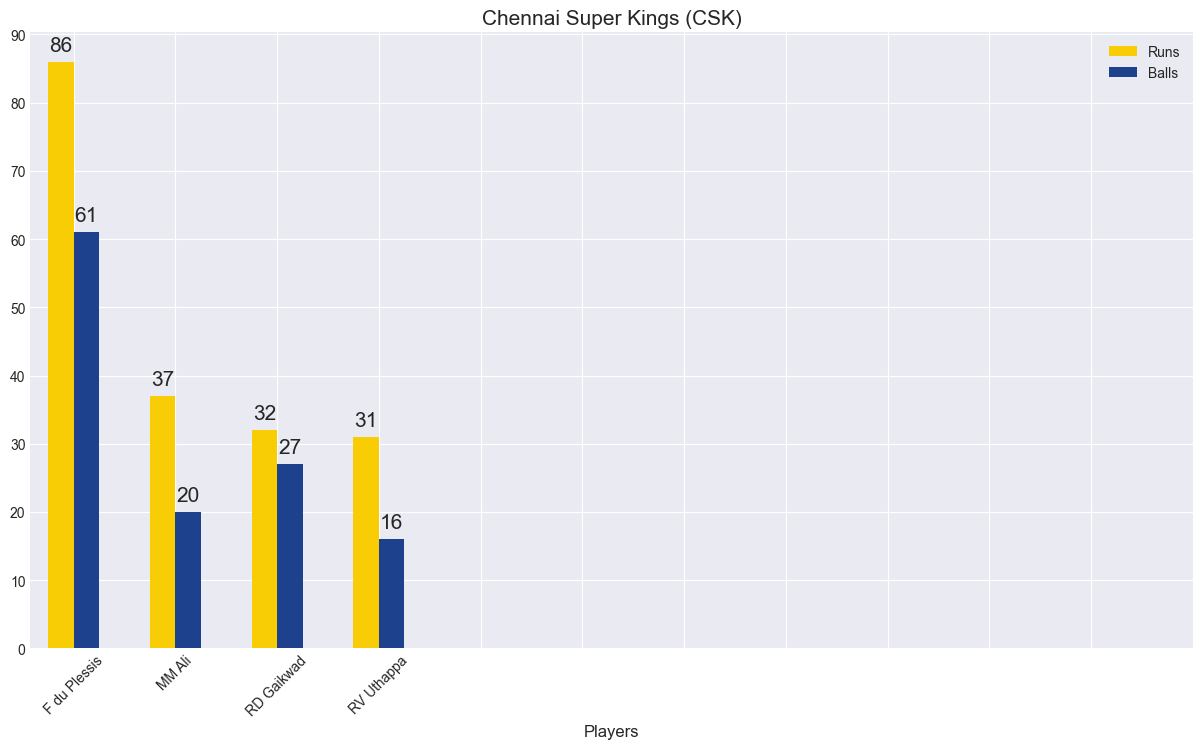

In [21]:
fig, ax = plt.subplots(figsize=(15, 8))

width = .25
x = np.arange(len(team_1_batsmen))

ax.bar(
    x - width/2,
    team_1_batsmen['runs'],
    width=width,
    color=color_1[0],
    label='Runs'
)

ax.bar(
    x + width/2,
    team_1_batsmen['balls'],
    width=width,
    color=color_1[1],
    label='Balls'
)

for score in ax.containers:
    ax.bar_label(score, size=15, padding=5)

ax.set_title(f'{team_names[0]} ({team_abbreviation[0]})', size=15)

ax.set_xlabel('Players', size=12)

ax.set_xticks(
    np.arange(12),
    team_1_batsmen['batsman'].tolist() + ([''] * (12 - len(team_1_batsmen['batsman']))),
    size=10,
    rotation=45
)

ax.set_yticks(np.linspace(start, end, step))

ax.legend(prop={'size': 10})
plt.show();

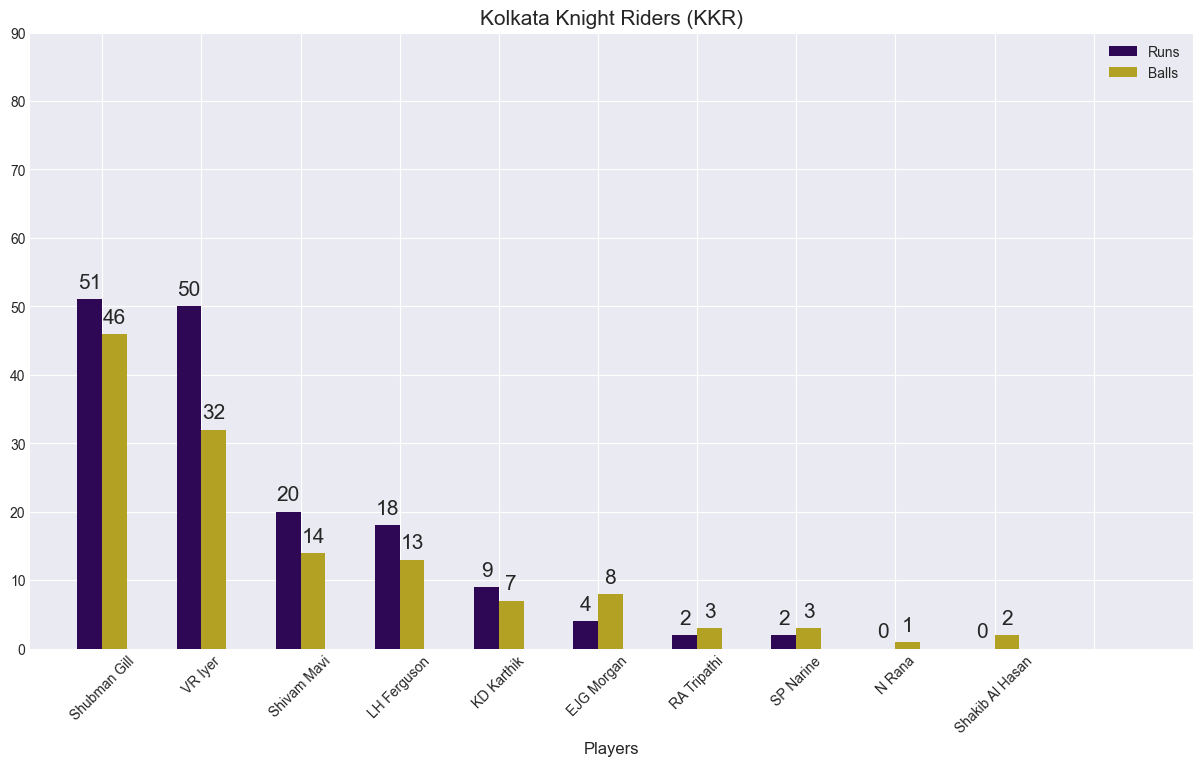

In [22]:
fig, ax = plt.subplots(figsize=(15, 8))

width = .25
x = np.arange(len(team_2_batsmen))

ax.bar(
    x - width/2,
    team_2_batsmen['runs'],
    width=width,
    color=color_2[0],
    label='Runs'
)

ax.bar(
    x + width/2,
    team_2_batsmen['balls'],
    width=width,
    color=color_2[1],
    label='Balls'
)

for score in ax.containers:
    ax.bar_label(score, size=15, padding=5)

ax.set_title(f'{team_names[1]} ({team_abbreviation[1]})', size=15)

ax.set_xlabel('Players', size=12)

ax.set_xticks(
    np.arange(12),
    team_2_batsmen['batsman'].tolist() + ([''] * (12 - len(team_2_batsmen['batsman']))),
    size=10,
    rotation=45
)

ax.set_yticks(np.linspace(start, end, step))

ax.legend(prop={'size': 10})
plt.show();

---